In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.2 ; cuda:  cu121
detectron2: 0.6


In [3]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [4]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/drive/MyDrive/Detectron2_with_wbc_+_rbc_+_platelet/train/training_COCO_JSON_wbc_all_granule_annotation.json", "/content/drive/MyDrive/Detectron2_with_wbc_+_rbc_+_platelet/train")
register_coco_instances("my_dataset_val", {}, "/content/drive/MyDrive/Detectron2_with_wbc_+_rbc_+_platelet/val/validation_COCO_JSON_wbc_all_granule_annotation.json", "/content/drive/MyDrive/Detectron2_with_wbc_+_rbc_+_platelet/val")


In [5]:
train_metadata = MetadataCatalog.get("my_dataset_train")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train")

val_metadata = MetadataCatalog.get("my_dataset_val")
val_dataset_dicts = DatasetCatalog.get("my_dataset_val")

[03/17 20:18:34 d2.data.datasets.coco]: Loaded 12 images in COCO format from /content/drive/MyDrive/Detectron2_with_wbc_+_rbc_+_platelet/train/training_COCO_JSON_wbc_all_granule_annotation.json
[03/17 20:18:35 d2.data.datasets.coco]: Loaded 2 images in COCO format from /content/drive/MyDrive/Detectron2_with_wbc_+_rbc_+_platelet/val/validation_COCO_JSON_wbc_all_granule_annotation.json


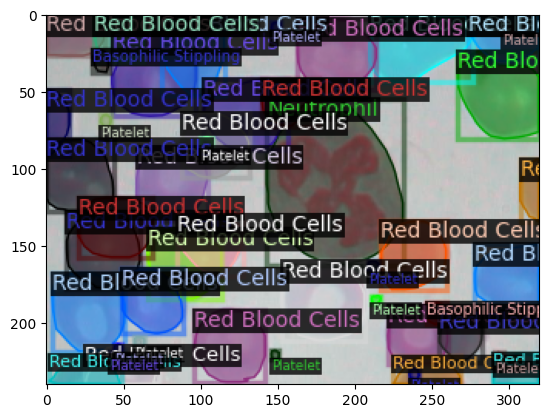

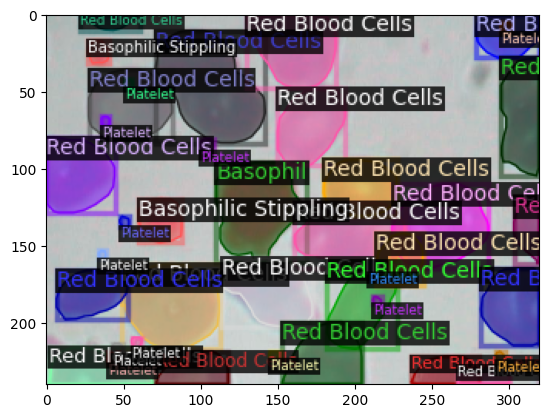

In [7]:
from matplotlib import pyplot as plt
for d in random.sample(train_dataset_dicts, 2): # visualizing 2 random image from the training set(5 images) using the data_dict and metadata;
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()


In [8]:
from detectron2.engine import DefaultTrainer
cfg = get_cfg()
cfg.OUTPUT_DIR = "/content/drive/MyDrive/Detectron2_with_wbc_+_rbc_+_platelet/model_storage"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 2500
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)


[03/17 20:21:21 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:01, 96.7MB/s]                          
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


In [9]:
trainer.train() # the training;

[03/17 20:21:31 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[03/17 20:21:45 d2.utils.events]:  eta: 0:19:27  iter: 19  total_loss: 7.012  loss_cls: 1.947  loss_box_reg: 0.8242  loss_mask: 0.6937  loss_rpn_cls: 3.302  loss_rpn_loc: 0.2754    time: 0.4813  last_time: 0.4553  data_time: 0.0360  last_data_time: 0.0055   lr: 4.9953e-06  max_mem: 2244M
[03/17 20:21:57 d2.utils.events]:  eta: 0:18:33  iter: 39  total_loss: 5.171  loss_cls: 1.825  loss_box_reg: 0.7908  loss_mask: 0.6846  loss_rpn_cls: 1.583  loss_rpn_loc: 0.2295    time: 0.4668  last_time: 0.4464  data_time: 0.0082  last_data_time: 0.0058   lr: 9.9902e-06  max_mem: 2244M
[03/17 20:22:07 d2.utils.events]:  eta: 0:18:30  iter: 59  total_loss: 3.694  loss_cls: 1.606  loss_box_reg: 0.719  loss_mask: 0.6699  loss_rpn_cls: 0.4053  loss_rpn_loc: 0.1937    time: 0.4696  last_time: 0.4668  data_time: 0.0082  last_data_time: 0.0061   lr: 1.4985e-05  max_mem: 2247M
[03/17 20:22:16 d2.utils.events]:  eta: 0:18:21  iter: 79  total_loss: 2.987  loss_cls: 1.295  loss_box_reg: 0.6623  loss_mask: 0.652

In [10]:
import yaml
config_yaml_path = "/content/drive/MyDrive/Detectron2_with_wbc_+_rbc_+_platelet/model_storage/config.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

In [11]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "/content/drive/MyDrive/Detectron2_with_wbc_+_rbc_+_platelet/model_storage/model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

[03/17 20:43:59 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/Detectron2_with_wbc_+_rbc_+_platelet/model_storage/model_final.pth ...


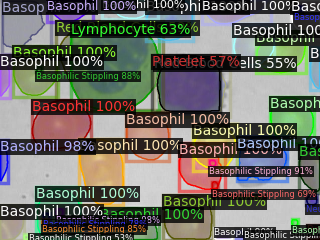

In [12]:
from detectron2.utils.visualizer import ColorMode
for d in random.sample(val_dataset_dicts, 1):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [13]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[03/17 20:45:06 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[03/17 20:45:06 d2.data.datasets.coco]: Loaded 2 images in COCO format from /content/drive/MyDrive/Detectron2_with_wbc_+_rbc_+_platelet/val/validation_COCO_JSON_wbc_all_granule_annotation.json
[03/17 20:45:06 d2.data.build]: Distribution of instances among all 6 categories:
|  category  | #instances   |  category  | #instances   |   category    | #instances   |
|:----------:|:-------------|:----------:|:-------------|:-------------:|:-------------|
|  Basophil  | 2            | Lymphocyte | 0            | Red Blood C.. | 46           |
|  Platelet  | 26           | Neutrophil | 2            | Basophilic .. | 10           |
|            |              |            |              |               |              |
|   total    | 86           |            |              |               |              |
[03/17 20:45:06 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in

In [31]:
new_im = cv2.imread("/content/drive/MyDrive/Detectron2_with_wbc_+_rbc_+_platelet/selected_testing/test_BloodImage_203.jpg")
outputs  = predictor(new_im)

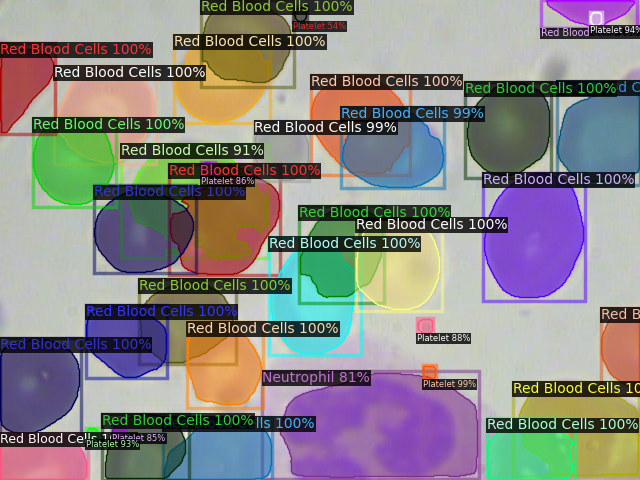

In [32]:
v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

cv2_imshow(out.get_image()[:, :, ::-1])

In [18]:
input_images_directory = "/content/drive/MyDrive/Detectron2_with_wbc_+_rbc_+_platelet/selected_testing"
output_directory = "/content/drive/MyDrive/Detectron2_with_wbc_+_rbc_+_platelet/predicted_detected_segmented_results"
for image_filename in os.listdir(input_images_directory):
    image_path = os.path.join(input_images_directory, image_filename)
    new_im = cv2.imread(image_path)
    outputs = predictor(new_im)
    v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    result_filename = os.path.splitext(image_filename)[0] + "_result.png"
    output_path = os.path.join(output_directory, result_filename)
    cv2.imwrite(output_path, out.get_image()[:, :, ::-1])
print("Segmentation of all images completed.")

Segmentation of all images completed.


In [28]:
import csv
from skimage.measure import regionprops, label
input_images_directory = "/content/drive/MyDrive/Detectron2_with_wbc_+_rbc_+_platelet/selected_testing"
output_csv_path = "/content/drive/MyDrive/Detectron2_with_wbc_+_rbc_+_platelet/predicted_detected_segmented_results/output_recognized_objects.csv"
with open(output_csv_path, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(["File Name", "Class Name", "Object Number", "Area", "Centroid", "BoundingBox"])
    for image_filename in os.listdir(input_images_directory):
        image_path = os.path.join(input_images_directory, image_filename)
        new_im = cv2.imread(image_path)
        if new_im is not None:
            outputs = predictor(new_im)
            mask = outputs["instances"].pred_masks.to("cpu").numpy().astype(bool)
            class_labels = outputs["instances"].pred_classes.to("cpu").numpy()
            labeled_mask = label(mask)
            props = regionprops(labeled_mask)
            for i, prop in enumerate(props):
                object_number = i + 1
                area = prop.area
                centroid = prop.centroid
                bounding_box = prop.bbox
                if i < len(class_labels):
                    class_label = class_labels[i]
                    class_name = train_metadata.thing_classes[class_label]
                else:
                    class_name = 'Unknown'
                csvwriter.writerow([image_filename, class_name, object_number, area, centroid, bounding_box])

print("Object-level information saved to CSV file.")


Object-level information saved to CSV file.


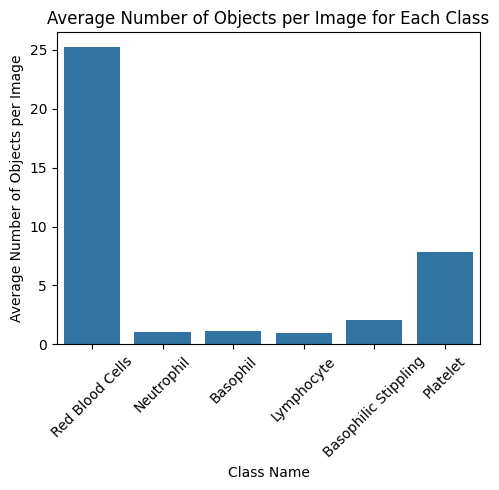

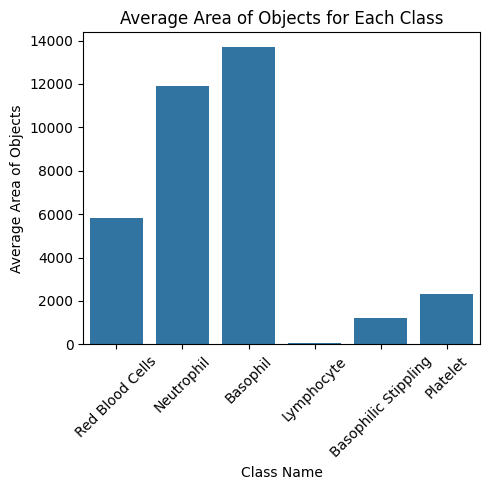

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
csv_file_path = "/content/drive/MyDrive/Detectron2_with_wbc_+_rbc_+_platelet/predicted_detected_segmented_results/output_recognized_objects.csv"
df = pd.read_csv(csv_file_path)
class_names = train_metadata.thing_classes
avg_objects_per_class = df.groupby(["File Name", "Class Name"])["Object Number"].count().reset_index()
avg_objects_per_class = avg_objects_per_class.groupby("Class Name")["Object Number"].mean().reset_index()
plt.figure(figsize=(5, 5))
sns.barplot(x="Class Name", y="Object Number", data=avg_objects_per_class, errorbar=None, order=class_names)
plt.xticks(rotation=45)
plt.xlabel("Class Name")
plt.ylabel("Average Number of Objects per Image")
plt.title("Average Number of Objects per Image for Each Class")
plt.tight_layout()
plt.show()
avg_area_per_class = df.groupby("Class Name")["Area"].mean().reset_index()
plt.figure(figsize=(5, 5))
sns.barplot(x="Class Name", y="Area", data=avg_area_per_class, errorbar=None, order=class_names)
plt.xticks(rotation=45)
plt.xlabel("Class Name")
plt.ylabel("Average Area of Objects")
plt.title("Average Area of Objects for Each Class")
plt.tight_layout()
plt.show()

In [30]:
import os
import cv2
import numpy as np
import torch
from detectron2.utils.visualizer import Visualizer
input_images_directory = "/content/drive/MyDrive/Detectron2_with_wbc_+_rbc_+_platelet/selected_testing"
output_directory = "/content/drive/MyDrive/Detectron2_with_wbc_+_rbc_+_platelet/predicted_ground_truths_test_images"
for image_filename in os.listdir(input_images_directory):
    image_path = os.path.join(input_images_directory, image_filename)
    new_im = cv2.imread(image_path)
    if new_im is not None:
        outputs = predictor(new_im)
        class_masks = {class_name: torch.zeros_like(outputs["instances"].pred_masks[0], dtype=torch.uint8, device=torch.device("cuda:0"))
                    for class_name in train_metadata.thing_classes}
        for i, pred_class in enumerate(outputs["instances"].pred_classes):
            class_name = train_metadata.thing_classes[pred_class]
            class_masks[class_name] = torch.where(outputs["instances"].pred_masks[i].to(device=torch.device("cuda:0")),
                                                i + 1,
                                                class_masks[class_name])
        for class_name, class_mask in class_masks.items():
            class_mask_np = class_mask.cpu().numpy()
            class_filename = os.path.splitext(image_filename)[0] + f"_{class_name}_result.png"
            class_output_path = os.path.join(output_directory, class_filename)
            cv2.imwrite(class_output_path, class_mask_np.astype(np.uint8))
print("Segmentation of all images completed.")

Segmentation of all images completed.
